In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout


In [2]:
epochs = 20
learning_rate = 3.9e-5
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
folder_path = './../../datasets/dataset1'
num_classes = 5
validation_split = 0.2
test_split = 0.2  # Proportion of the data to use for testing

# Load image file paths and their corresponding labels
image_paths = []
labels = []

class_names = sorted(os.listdir(folder_path))
class_indices = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        image_paths.append(file_path)
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_split, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=validation_split, stratify=train_labels, random_state=42)

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    label = tf.one_hot(label, num_classes)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)



In [3]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [4]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [5]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)], zero_division=0))

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    # Plot the confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])

    

In [6]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 classes for diabetic retinopathy
model = Model(inputs=base_model.input, outputs=output)

In [7]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

train_accuracy->  [0.7313167452812195, 0.7346975207328796, 0.7347864508628845, 0.7347864508628845, 0.7347864508628845, 0.7347419857978821, 0.7348309755325317, 0.7348754405975342, 0.7348309755325317, 0.7348309755325317, 0.7349199056625366, 0.7349644303321838, 0.7348754405975342, 0.7350088953971863, 0.735231339931488, 0.7349644303321838, 0.7353647947311401, 0.7350978851318359, 0.7353202700614929, 0.7350088953971863]
val_accuracy->  [0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7350533604621887, 0.7350533604621887, 0.7350533604621887, 0.7350533604621887, 0.7350533604621887, 0.7350533604621887, 0.7348754405975342, 0.7348754405975342, 0.7350533604621887, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342]
train_loss->  [0.9048207998275757, 0.8799033164978027, 0.8663649559020996, 0.8627686500549316, 0.8542295694351196, 0.8536762595176697, 0.8438804745674133, 0.84083700

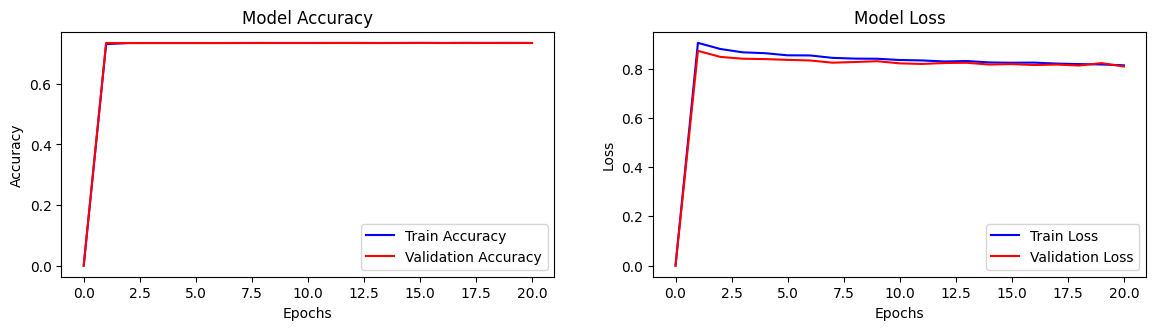

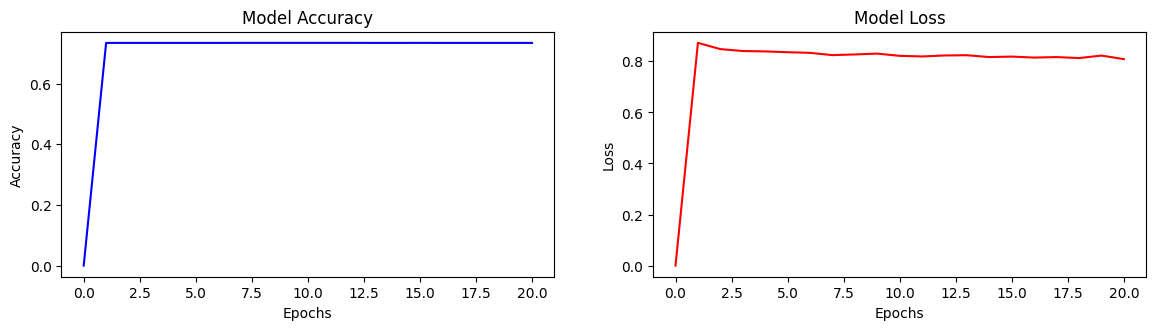

In [8]:
accuracyGraph(history)

220/220 [==============================] - 19s 85ms/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5162
           1       0.00      0.00      0.00       489
           2       0.00      0.00      0.00      1058
           3       0.00      0.00      0.00       175
           4       0.50      0.01      0.01       142

    accuracy                           0.73      7026
   macro avg       0.25      0.20      0.17      7026
weighted avg       0.55      0.73      0.62      7026

[[5161    0    0    0    1]
 [ 489    0    0    0    0]
 [1058    0    0    0    0]
 [ 175    0    0    0    0]
 [ 141    0    0    0    1]]


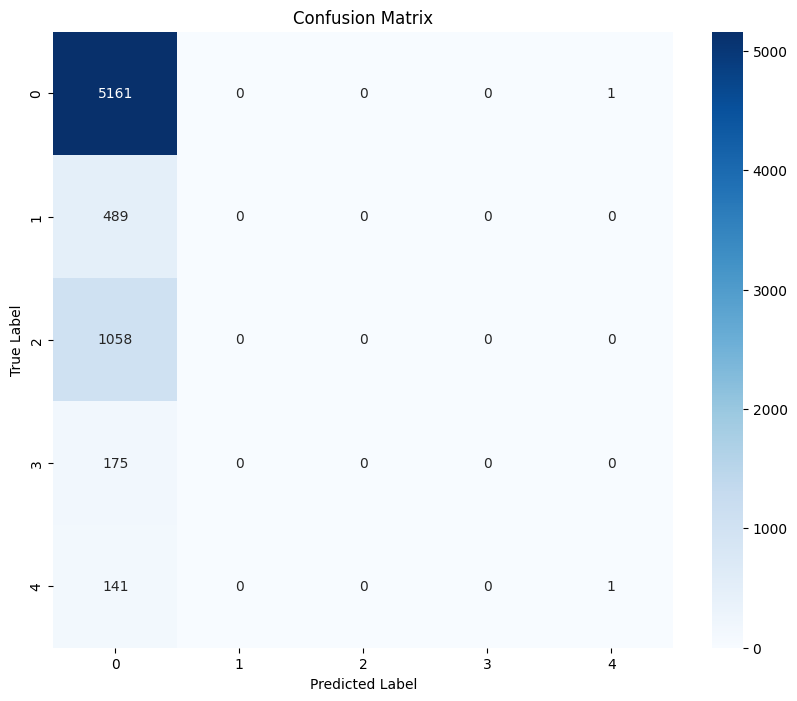

In [9]:
show_confusion_matrix(model)

In [10]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 18s 82ms/step - loss: 0.8151 - accuracy: 0.7347 - auc: 0.9112 - balanced_accuracy: 0.2658 - fscore: 0.2257 - kappa_score: 5.7357e-04 - precision: 0.7413 - recall: 0.7257
Test Metrices [0.8150972723960876, 0.7346996665000916, 0.9111688733100891, 0.2658402919769287, 0.22574107348918915, 0.0005735701997764409, 0.7413492202758789, 0.7257329821586609]


In [11]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:15]:   
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Epoch 1/20


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


703/703 [==============================] - 122s 142ms/step - loss: 0.8842 - accuracy: 0.7330 - auc: 0.8949 - balanced_accuracy: 0.2673 - fscore: 0.2273 - kappa_score: -6.4231e-04 - precision: 0.7369 - recall: 0.7226 - val_loss: 0.8369 - val_accuracy: 0.7349 - val_auc: 0.9057 - val_balanced_accuracy: 0.2670 - val_fscore: 0.2271 - val_kappa_score: 0.0000e+00 - val_precision: 0.7352 - val_recall: 0.7345
Epoch 2/20
703/703 [==============================] - 119s 143ms/step - loss: 0.8410 - accuracy: 0.7349 - auc: 0.9028 - balanced_accuracy: 0.2670 - fscore: 0.2269 - kappa_score: 0.0023 - precision: 0.7419 - recall: 0.7218 - val_loss: 0.8035 - val_accuracy: 0.7349 - val_auc: 0.9140 - val_balanced_accuracy: 0.2681 - val_fscore: 0.2273 - val_kappa_score: 6.4231e-04 - val_precision: 0.7532 - val_recall: 0.7226
Epoch 3/20
703/703 [==============================] - 120s 144ms/step - loss: 0.8107 - accuracy: 0.7366 - auc: 0.9113 - balanced_accuracy: 0.2770 - fscore: 0.2389 - kappa_score: 0.0291 -

train_accuracy->  [0.7329626083374023, 0.7349199056625366, 0.7366102933883667, 0.7415035367012024, 0.7453292012214661, 0.7510676383972168, 0.7553825378417969, 0.7644128203392029, 0.7746886014938354, 0.7901690602302551, 0.8046708106994629, 0.8276690244674683, 0.8516014218330383, 0.8719750642776489, 0.8998220562934875, 0.9175711870193481, 0.9329626560211182, 0.9416370391845703, 0.9537366628646851, 0.9558274149894714]
val_accuracy->  [0.7348754405975342, 0.7348754405975342, 0.7428825497627258, 0.7435942888259888, 0.7386121153831482, 0.7441281080245972, 0.7498220801353455, 0.7427046298980713, 0.7459074854850769, 0.7508896589279175, 0.7435942888259888, 0.7074733376502991, 0.7033807635307312, 0.6964412927627563, 0.6798932552337646, 0.6722419857978821, 0.6574733257293701, 0.7323843240737915, 0.7291814684867859, 0.6772242188453674]
train_loss->  [0.8841745853424072, 0.8409721255302429, 0.8106807470321655, 0.7859830260276794, 0.7650997638702393, 0.7395161986351013, 0.7151592373847961, 0.6849151

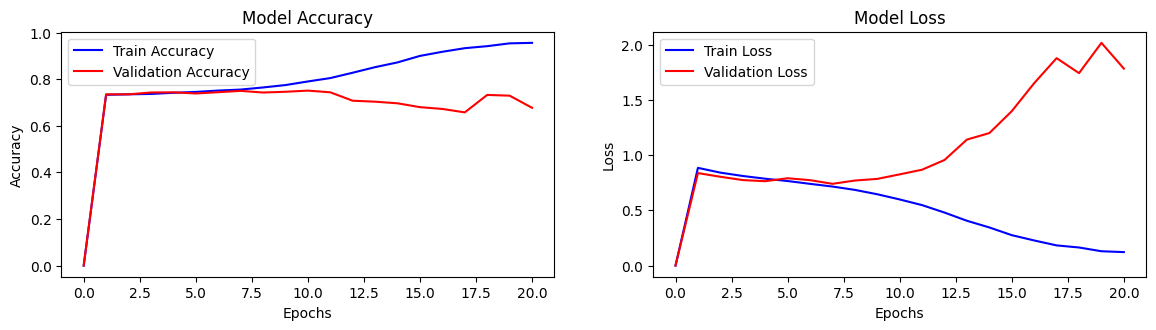

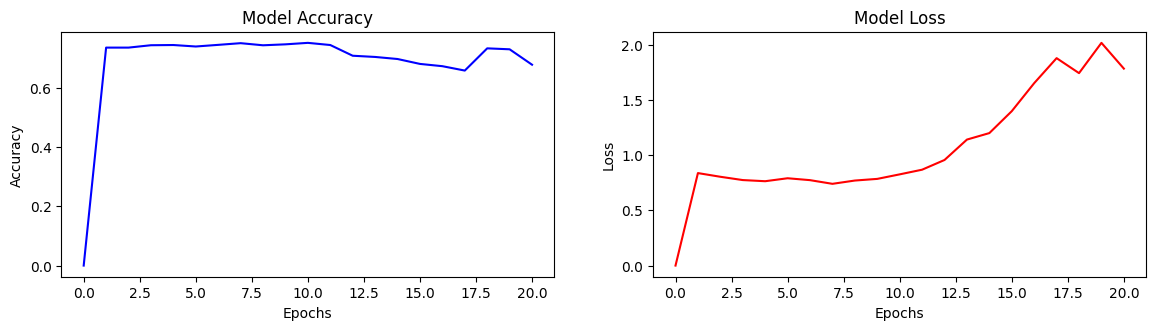

In [12]:
accuracyGraph(history)

220/220 [==============================] - 17s 76ms/step
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      5162
           1       0.11      0.07      0.09       489
           2       0.29      0.28      0.29      1058
           3       0.25      0.15      0.19       175
           4       0.30      0.18      0.22       142

    accuracy                           0.67      7026
   macro avg       0.35      0.30      0.32      7026
weighted avg       0.65      0.67      0.66      7026

[[4328  216  562   17   39]
 [ 380   36   70    3    0]
 [ 649   58  301   39   11]
 [  58   12   72   26    7]
 [  49    3   45   20   25]]


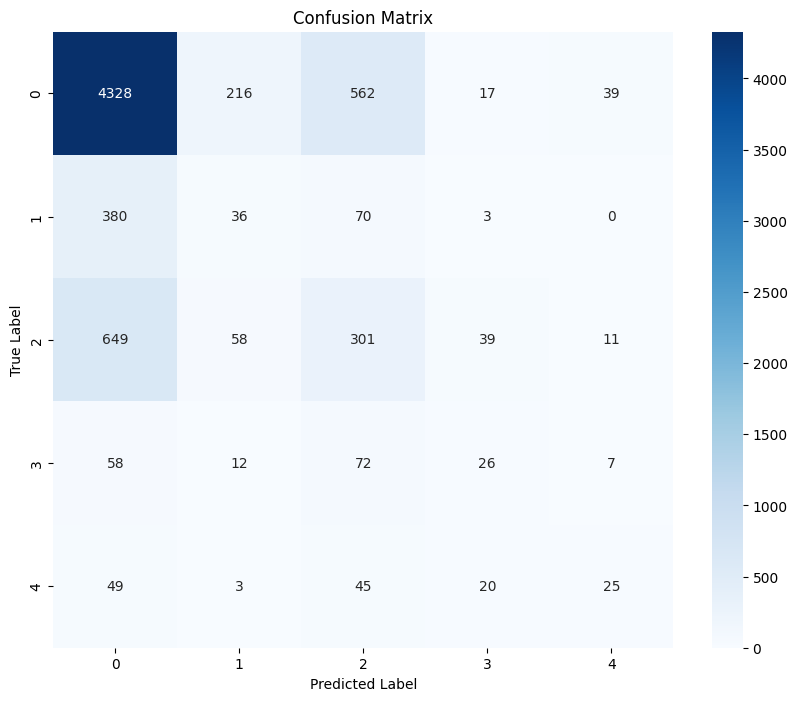

In [13]:
show_confusion_matrix(model)

In [14]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

220/220 [==============================] - 18s 82ms/step - loss: 1.8179 - accuracy: 0.6712 - auc: 0.8683 - balanced_accuracy: 0.3497 - fscore: 0.3060 - kappa_score: 0.1710 - precision: 0.6796 - recall: 0.6623
Test Metrices [1.8178510665893555, 0.6712211966514587, 0.8682722449302673, 0.34970182180404663, 0.3060474693775177, 0.17100262641906738, 0.6795676946640015, 0.6622545123100281]
